## Делаем подмодельку

In [11]:
from blocksnet import City

city = City.from_pickle('./data/model.pickle')

In [12]:
from blocksnet import Accessibility

block_id = city[3139]
acc = Accessibility(city_model=city).calculate(block_id)
acc = acc[acc['accessibility_to']<=5]

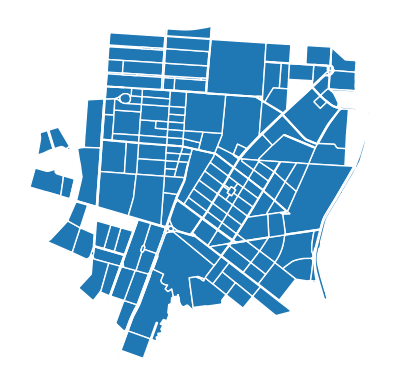

In [13]:
acc.plot().set_axis_off()

In [14]:
blocks_ids = acc.index
city._blocks = {b_id : city[b_id] for b_id in blocks_ids}
adj_mx = city.adjacency_matrix.copy()
adj_mx = adj_mx[blocks_ids]
adj_mx = adj_mx[adj_mx.index.isin(blocks_ids)]
city.adjacency_matrix = adj_mx.copy()

In [15]:
city = City(city.get_blocks_gdf(), city.adjacency_matrix.copy())

## Отжиг

In [16]:
from blocksnet import LandUse
import math

class Indicator:
    def __init__(self, fsi_min, fsi_max, gsi_min, gsi_max):
        self.fsi_min = fsi_min  # минимальный коэффициент плотности застройки
        self.fsi_max = fsi_max  # максимальный коэффициент плотности застройки
        self.gsi_min = gsi_min  # минимальный процент застроенности участка
        self.gsi_max = gsi_max  # максимальный процент застроенности участка

LAND_USE_INDICATORS = {
    LandUse.RESIDENTIAL: Indicator(fsi_min=0.5, fsi_max=3.0, gsi_min=0.2, gsi_max=0.8),
    LandUse.BUSINESS: Indicator(fsi_min=1.0, fsi_max=3.0, gsi_min=0.0, gsi_max=0.8),
    LandUse.RECREATION: Indicator(fsi_min=0.05, fsi_max=0.2, gsi_min=0.0, gsi_max=0.3),
    LandUse.SPECIAL: Indicator(fsi_min=0.05, fsi_max=0.2, gsi_min=0.05, gsi_max=0.15),
    LandUse.INDUSTRIAL: Indicator(fsi_min=0.3, fsi_max=1.5, gsi_min=0.2, gsi_max=0.8),
    LandUse.AGRICULTURE: Indicator(fsi_min=0.1, fsi_max=0.2, gsi_min=0.0, gsi_max=0.6),
    LandUse.TRANSPORT: Indicator(fsi_min=0.2, fsi_max=1.0, gsi_min=0.0, gsi_max=0.8),
}

VACANT_AREA_COEF = 0.8
LIVING_AREA_DEMAND = 20

def get_footprint_area(gsi, site_area):
    return site_area * gsi

def get_build_floor_area(fsi, site_area):
    return site_area * fsi

def get_integrated_area(build_floor_area, footprint_area, land_use):
    if land_use == LandUse.RESIDENTIAL:
        return footprint_area
    else : return build_floor_area
    
def get_living_area(build_floor_area, integrated_area, land_use):
    if land_use == LandUse.RESIDENTIAL:
        return build_floor_area - integrated_area
    else : return 0

def get_population(living_area):
    return math.floor(living_area/LIVING_AREA_DEMAND)

def get_non_integrated_area(site_area, footprint_area):
    return site_area*VACANT_AREA_COEF - footprint_area

def calculate_indicators(site_area, land_use, fsi, gsi):
    footprint_area = get_footprint_area(gsi, site_area)
    build_floor_area = get_build_floor_area(fsi, site_area)
    integrated_area = get_integrated_area(build_floor_area, footprint_area, land_use)
    living_area = get_living_area(build_floor_area, integrated_area, land_use)
    non_integrated_area = get_non_integrated_area(site_area, footprint_area)
    population = get_population(living_area)
    return {
        'footprint_area' : footprint_area,
        'build_floor_area' : build_floor_area,
        'integrated_area' : integrated_area,
        'non_integrated_area': non_integrated_area,
        'living_area': living_area,
        'population': population
    }

In [17]:
import pandas as pd
import random

input = {block : random.choice(list(LandUse)) for block in city.blocks}
fsis = {b : LAND_USE_INDICATORS[lu].fsi_min for b, lu in input.items()}
gsis = {b : LAND_USE_INDICATORS[lu].gsi_min for b, lu in input.items()}


class Variable():
  def __init__(self, brick, value=0):
    self.brick = brick
    self.value = value

variables = {}
for block, land_use in input.items():
  variables[block] = {}
  land_use = input[block]
  indicators = calculate_indicators(block.site_area, land_use, fsis[block], gsis[block])
  integrated_area = indicators['integrated_area']
  non_integrated_area = indicators['non_integrated_area']
  for st in city.get_land_use_service_types(land_use):
    variables[block][st] = []
    for br in st.bricks:
      variable = Variable(br)
      # variables[block][st].append(variable)
      variables[block][st] = [variable]

def flatten(variables):
  return [v3 for v1 in variables.values() for v2 in v1.values() for v3 in v2]

def to_update_df(variables):
  blocks_dicts = []
  for block, st_dict in variables.items():
    block_dict = {'id': block.id, 'population': calculate_indicators(block.site_area, input[block], fsis[block], gsis[block])['population']}
    for st, vars in st_dict.items():
      capacity = sum([var.brick.capacity * var.value for var in vars])
      block_dict.update({st.name: capacity})
    blocks_dicts.append(block_dict)
  return pd.DataFrame(blocks_dicts).set_index('id', drop=True)

In [18]:
from blocksnet import Provision
from loguru import logger
import random
from multiprocessing import Pool
import statistics

NUM_INDICES = 1

logger.disable('blocksnet.method.provision')

prov = Provision(city_model=city)

def calculate_provision(tpl):
    st = tpl[0]
    update_df = tpl[1]
    # bounds = prov.get_bounds(st, update_df)
    # return statistics.mean(bounds)
    if st.name not in update_df.columns or update_df[st.name].sum() == 0:
      return 0
    else: return prov.total_provision(prov.calculate(st, update_df, self_supply=True))

def total_provision(update_df):
  with Pool() as pool:
    res = pool.map(calculate_provision, [(st, update_df) for st in city.service_types])
  total = statistics.mean(res)
  logger.info(total)
  return total

def objective(variables):
    update_df = to_update_df(variables)
    total = total_provision(update_df)
    return total

def check_constraints(variables):
  for block, st_dict in variables.items():
    indicators = calculate_indicators(block.site_area, input[block], fsis[block], gsis[block])
    integrated_area = indicators['integrated_area']
    non_integrated_area = indicators['non_integrated_area']
    for st, vars in st_dict.items():
      if any([var.value < 0 for var in vars]) : return False
      integrated_vars = filter(lambda var : var.brick.is_integrated, vars)
      non_integrated_vars = filter(lambda var : not var.brick.is_integrated, vars)
      if sum([var.brick.area * var.value for var in integrated_vars]) > integrated_area : return False
      if sum([var.brick.area * var.value for var in non_integrated_vars]) > non_integrated_area : return False
  return True

def copy_variables(variables):
    return {b : {st : [Variable(var.brick, var.value) for var in vars] for st, vars in st_dict.items()} for b, st_dict in variables.items()}

def perturb(variables):
    variables = copy_variables(variables)
    block = random.choice(list(variables.keys()))
    service_type = random.choice(list(variables[block].keys()))
    variable = random.choice(list(variables[block][service_type]))
    # variable.value = random.choice([0,1])
    change = random.choice([-1, 1])  # Изменяем переменную на 1 или -1
    variable.value += change
    return variables

In [19]:
T_MAX = 100
T_MIN = 1e-3
COOLING_RATE = 0.95
MAX_ITER = 500

def simulated_annealing(initial_solution):
    # Начальное решение
    X_current = initial_solution
    best_solution = X_current
    best_value = objective(X_current) if check_constraints(X_current) else float('-inf')
    
    # Начальная температура
    T = T_MAX
    
    for i in range(MAX_ITER):
        # Генерируем новое решение
        X_new = perturb(X_current)
        
        # Проверка ограничений
        if not check_constraints(X_new):
            continue
        
        # Вычисляем целевые функции
        current_value = objective(X_current)
        new_value = objective(X_new)
        
        # Если новое решение лучше, принимаем его
        if new_value > current_value:
            X_current = X_new
        else:
            # Принимаем хужее решение с вероятностью, зависящей от температуры
            delta = new_value - current_value
            if random.random() < math.exp(delta / T):
                X_current = X_new

        # Обновляем лучшее решение
        if objective(X_current) > best_value:
            best_solution = X_current
            best_value = objective(X_current)

        
        # Охлаждаем температуру
        T = T * COOLING_RATE
        if T < T_MIN:
            break

    return best_solution, best_value

In [20]:
sol, val = simulated_annealing(variables)

2024-09-05 02:56:37.999 | INFO     | __main__:total_provision:26 - 0
2024-09-05 02:56:39.062 | INFO     | __main__:total_provision:26 - 0
2024-09-05 02:56:39.406 | INFO     | __main__:total_provision:26 - 0.015151515151515152
2024-09-05 02:56:39.774 | INFO     | __main__:total_provision:26 - 0.015151515151515152
2024-09-05 02:56:40.133 | INFO     | __main__:total_provision:26 - 0.015151515151515152
2024-09-05 02:56:40.523 | INFO     | __main__:total_provision:26 - 0.015151515151515152
2024-09-05 02:56:40.880 | INFO     | __main__:total_provision:26 - 0.01632101460574874
2024-09-05 02:56:41.273 | INFO     | __main__:total_provision:26 - 0.01632101460574874
2024-09-05 02:56:41.639 | INFO     | __main__:total_provision:26 - 0.01632101460574874
2024-09-05 02:56:42.305 | INFO     | __main__:total_provision:26 - 0.01632101460574874
2024-09-05 02:56:42.669 | INFO     | __main__:total_provision:26 - 0.02230187584976788
2024-09-05 02:56:43.018 | INFO     | __main__:total_provision:26 - 0.022301